In [1]:
!pip install openpyxl

In [1]:
%matplotlib inline
# import os
# os.chdir('..')
from obspy import read, UTCDateTime as UTC
from obspy.signal.cross_correlation import correlation_detector
import obspy
import io
import matplotlib.pyplot as plt
# import helpers
import numpy as np
import pandas as pd

from obspy.signal import trigger
from obspy.signal import filter

from datetime import datetime

from multiprocessing import Pool
import glob

# import tempmatch as tm

from scipy.fft import fft, fftfreq
import scipy.stats as stats

def minmax(data):
    min = data.min()
    max = data.max()
    return (data - min)/(max - min)

In [2]:
# ba1d_pt = pd.read_excel('proposal/BA1D 2020_2021-10-07_14-46-39-815.xlsx')
ba1d_pt = pd.read_excel('BA1D 2020_2021-10-07_14-46-39-815.xlsx')
ba1d_pt.columns = [c.strip() for c in ba1d_pt.columns]
ba1d_pt['Date and Time'] = pd.to_datetime(ba1d_pt['Date and Time'])
ba1d_pt.set_index('Date and Time', inplace=True)

In [3]:
ba1d_pt.head()

,Elapsed Time (sec),Pressure (Bar),Temperature (C)
Date and Time,,,
2020-03-07 10:00:00,0,1.113,33.441
2020-03-07 10:15:00,900,1.097,34.674
2020-03-07 10:30:00,1800,1.097,34.674
2020-03-07 10:45:00,2700,1.097,34.721
2020-03-07 11:00:00,3600,1.097,34.674


In [4]:
ba1d_pt.columns

Index(['Elapsed Time (sec)', 'Pressure (Bar)', 'Temperature (C)'], dtype='object')

<AxesSubplot:xlabel='Date and Time'>

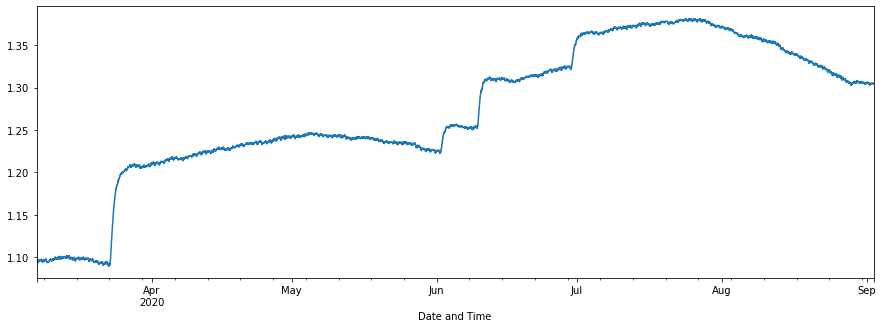

In [5]:
fig, ax = plt.subplots(figsize=(15, 5))
ba1d_pt['Pressure (Bar)'].plot()

<AxesSubplot:xlabel='Date and Time'>

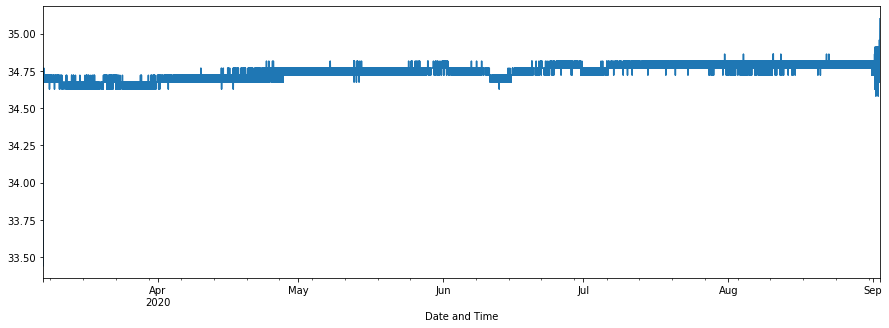

In [6]:
fig, ax = plt.subplots(figsize=(15, 5))
ba1d_pt['Temperature (C)'].plot()

In [7]:
# ba1b_waterlevel = pd.read_excel('proposal/BA1b_p_T_April2018_Jan2019_waterlevel.xlsx')
ba1b_waterlevel = pd.read_excel('BA1b_p_T_April2018_Jan2019_waterlevel.xlsx')
ba1b_waterlevel.columns = [c.strip() for c in ba1b_waterlevel.columns]
ba1b_waterlevel['Date'] = pd.to_datetime(ba1b_waterlevel['Date'])
ba1b_waterlevel.set_index('Date', inplace=True)
ba1b_waterlevel.head()

/home/john/anaconda3/envs/borehole/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Seconds,Pressure (mBar),meter water level,Temperature (C)
Date,,,,
2018-08-04 15:00:00,0.000,1645.098,16.45098,33.942
2018-08-04 15:15:00,900.001,1645.126,16.45126,33.895
2018-08-04 15:30:00,1800.001,1645.015,16.45015,33.895
2018-08-04 15:45:00,2700.001,1644.599,16.44599,33.942
2018-08-04 16:00:00,3600.001,1644.599,16.44599,33.942


<AxesSubplot:xlabel='Date'>

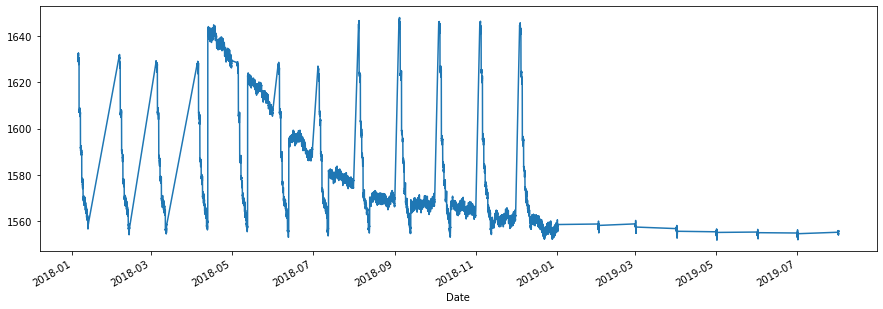

In [8]:
fig, ax = plt.subplots(figsize=(15, 5))
ba1b_waterlevel['Pressure (mBar)'].plot(ax=ax)

In [9]:
# ba1d_otherpt = pd.read_excel('proposal/BA1D_p_T_2019_2020_1.xlsx')
ba1d_otherpt = pd.read_excel('BA1D_p_T_2019_2020_1.xlsx')
ba1d_otherpt.columns = [c.strip() for c in ba1d_otherpt.columns]
ba1d_otherpt['Date and Time'] = pd.to_datetime(ba1d_otherpt['Date and Time'])
ba1d_otherpt.set_index('Date and Time', inplace=True)
# ba1d_otherpt['Pressure (Bar)'] = stats.zscore(ba1d_otherpt['Pressure (Bar)'])
# ba1d_otherpt['Temperature (C)'] = stats.zscore(ba1d_otherpt['Temperature (C)'])
ba1d_otherpt['Pressure (Bar)'] = minmax(ba1d_otherpt['Pressure (Bar)'])
ba1d_otherpt['Temperature (C)'] = minmax(ba1d_otherpt['Temperature (C)'])

ba1d_otherpt.head()

,Seconds,Pressure (Bar),Temperature (C)
Date and Time,,,
2019-01-18 11:15:00,0.0,0.021201,0.000000
2019-01-18 11:30:00,900.0,0.010601,0.860853
2019-01-18 11:45:00,1800.0,0.010601,0.884370
2019-01-18 12:00:00,2700.0,0.014134,0.884370
2019-01-18 12:15:00,3600.0,0.015901,0.884370


<AxesSubplot:xlabel='Date and Time'>

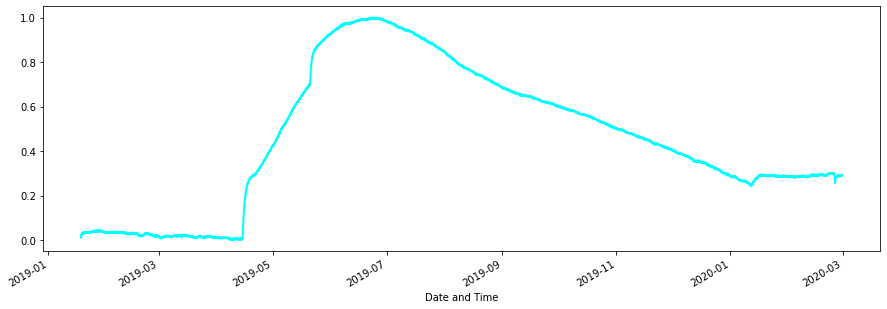

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
ba1d_otherpt['Pressure (Bar)'].plot(ax=ax, color='cyan', linewidth=2)
# (ba1d_otherpt['Temperature (C)']+1).plot(ax=ax, color='red', linewidth=2)

In [19]:
barolog = pd.read_excel('proposal/Barolog_May2019_March2020.xlsx')
barolog.columns = [c.strip() for c in barolog.columns]
barolog['Date and Time'] = pd.to_datetime(barolog['Date and Time'])
barolog.set_index('Date and Time', inplace=True)
barolog.head()

,Elapsed Seconds,Barometric Pressure (Bar),Temperature (C)
Date and Time,,,
2019-05-03 13:00:00,0,0.961,24.552
2019-05-03 13:15:00,900,0.964,24.356
2019-05-03 13:30:00,1800,0.951,24.209
2019-05-03 13:45:00,2700,0.949,25.677
2019-05-03 14:00:00,3600,0.949,27.088


<AxesSubplot:xlabel='Date and Time'>

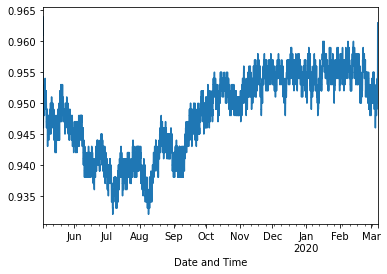

In [21]:
barolog['Barometric Pressure (Bar)'].plot()

In [12]:
events = pd.read_csv('proposal/cumevents.csv')
events['time'] = pd.to_datetime(events['time'])
events.set_index('time', inplace=True)
events.head()

,similarity,template_id,ones
time,,,
2019-05-07 16:37:35.302001+00:00,0.800337,0,1
2019-05-17 00:56:44.213000+00:00,0.801590,0,1
2019-05-18 11:45:45.948000+00:00,0.948577,0,1
2019-05-18 11:47:16.325000+00:00,0.962242,0,1
2019-05-18 11:47:54.450000+00:00,0.964003,0,1


In [ ]:
barolog2018 = pd.read_excel('proposal/Barolog_2018_2019.xlsx')
barolog2018.columns = [c.strip() for c in barolog2018.columns]
barolog2018['Date and Time'] = pd.to_datetime(barolog2018['Date and Time'])
barolog2018.set_index('Date and Time', inplace=True)
barolog2018.head()

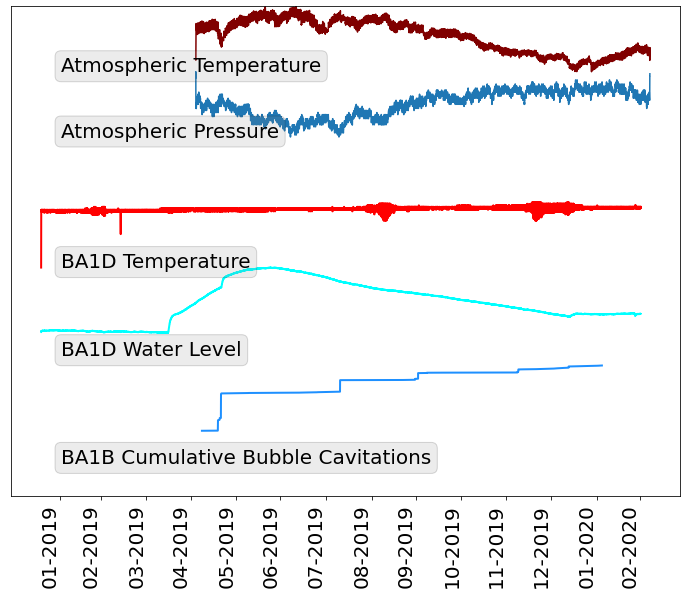

In [103]:
fontsize = 20

fig, ax = plt.subplots(figsize=(12, 10))
ba1d_otherpt['Pressure (Bar)'].plot(ax=ax, color='cyan', linewidth=2)
(ba1d_otherpt['Temperature (C)']+1).plot(ax=ax, color='red', linewidth=2)
(minmax(barolog['Barometric Pressure (Bar)'])+3).plot(ax=ax)
(minmax(barolog['Temperature (C)'])+4).plot(ax=ax, color='maroon')
(minmax(events.ones.cumsum())-1.5).plot(ax=ax, color='dodgerblue', linewidth=2)


ax.set_yticks([])
# ax.set_xlim('01-01-2019', '10-01-2020')
ax.text(s='BA1D Water Level', x='02-01-2019', y=-0.35, fontsize=fontsize, bbox=dict(facecolor='grey', alpha=0.15, boxstyle='round'))
ax.text(s='BA1D Temperature', x='02-01-2019', y=1, fontsize=fontsize, bbox=dict(facecolor='grey', alpha=0.15, boxstyle='round'))
ax.text(s='Atmospheric Pressure', x='02-01-2019', y=3, fontsize=fontsize, bbox=dict(facecolor='grey', alpha=0.15, boxstyle='round'))
ax.text(s='Atmospheric Temperature', x='02-01-2019', y=4, fontsize=fontsize, bbox=dict(facecolor='grey', alpha=0.15, boxstyle='round'))
ax.text(s='BA1B Cumulative Bubble Cavitations', x='02-01-2019', y=-2, fontsize=fontsize, bbox=dict(facecolor='grey', alpha=0.15, boxstyle='round'))
ax.set_ylim(-2.5, 5)
xticks = pd.date_range(start='01-01-2019', end='03-01-2020', freq='1m')
ax.set_xticks(xticks)
ax.set_xticklabels(['-'.join(reversed(str(x).split(' ')[0].split('-')[0:2])) for x in xticks], fontsize=fontsize, rotation=90)
ax.set_xlabel('')
fig.savefig('proposal/timeseriesdata.png', dpi=300, bbox_inches='tight')

<AxesSubplot:xlabel='Date and Time'>

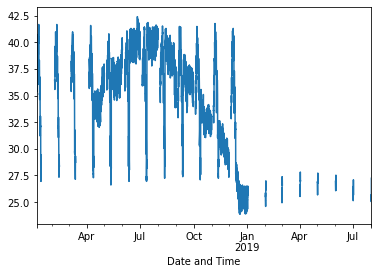

In [66]:
barolog2018.resample('15min').max()['Temperature (C)'].plot()

<AxesSubplot:xlabel='Date and Time'>

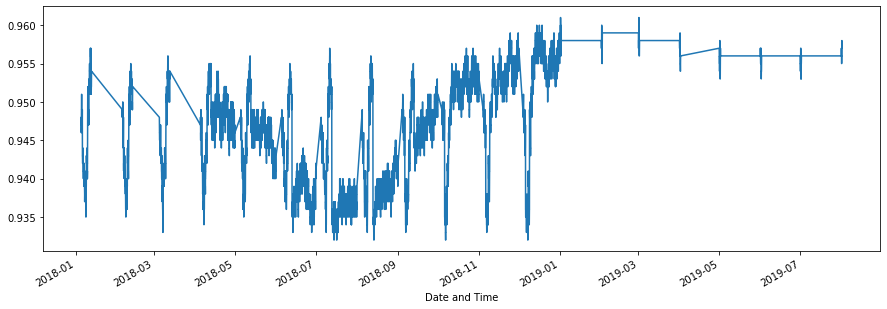

In [57]:
(barolog2018['Barometric Pressure (Bar)']).plot(figsize=(15,5))


<AxesSubplot:xlabel='Date and Time'>

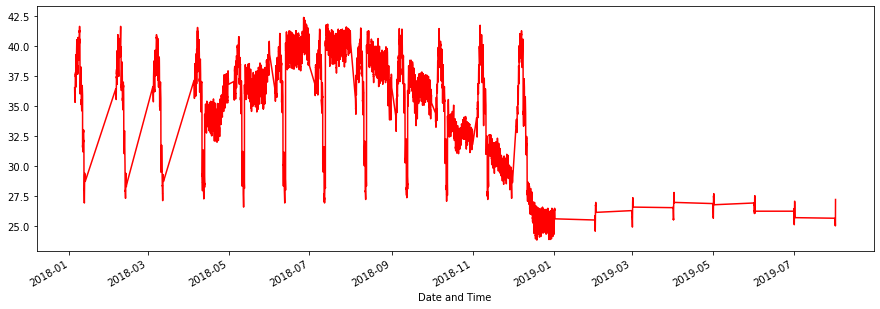

In [59]:
(barolog2018['Temperature (C)']).plot(figsize=(15,5), color='red')
